<a href="https://colab.research.google.com/github/ayaamr11/Pose-Detection/blob/main/Pose_detection_version1_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.io
import glob
from pathlib import Path


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import pickle

import imageio
from mlxtend.image import extract_face_landmarks
from google.colab.patches import cv2_imshow
import cv2
from math import cos, sin
import dlib


# Connect to my drive

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!ls "/content/drive/My Drive/Colab Notebooks/machine_learning_projects_data"

# Read data

In [ ]:
#unzip folder from drive
!unzip "/content/gdrive/MyDrive/Colab Notebooks/machine_learning_projects_data/AFLW2000-3D_.zip"

Archive:  /content/gdrive/MyDrive/Colab Notebooks/machine_learning_projects_data/AFLW2000-3D_.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mex

In [ ]:
#read Yaw, Pitch and Roll
def readMat_pose(filename):
    return scipy.io.loadmat(filename)['Pose_Para'][0][0:3] * 180/ math.pi


In [ ]:
#read all IMAGE points
def readMat_2d_pts(filename):
    return scipy.io.loadmat(filename)['pt3d_68'][0:2] 


In [ ]:
#retrive image poses and points into dataframe
def build_dataFrame():
  xList = []
  yList = []
  imag=['imag_name']
  posList=["pitch","yaw","roll"]
  for i in range(1,69):
    xFeature= "x" + str(i)
    yFeature= "y" + str(i)
    xList.append(xFeature)
    yList.append(yFeature)
  colNames =  xList + yList + posList +imag

  df=pd.DataFrame(columns=colNames)

  for file in glob.glob("/content/AFLW2000/*.mat"):
   #print(file)
   
   pointsList = readMat_2d_pts(file)
   poseList = readMat_pose(file)
   image=file

   record = [*pointsList.flatten().tolist(),*poseList.tolist(),image]
   #print(record)
   df.loc[len(df)] = record
  return df
  

In [ ]:
df = build_dataFrame()

In [ ]:
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y63,y64,y65,y66,y67,y68,pitch,yaw,roll,imag_name
0,209.940048,210.404358,213.663956,216.233856,217.749786,217.572693,215.871796,217.174484,230.818146,254.578125,...,293.536011,293.538025,299.430847,298.362427,299.290314,299.307922,5.052919,35.609653,-1.982180,/content/AFLW2000/image01238.mat
1,108.229164,109.456902,113.467911,118.374466,128.303024,143.724060,162.888474,188.527206,219.918365,246.622406,...,300.458160,300.011627,292.888123,307.587128,309.239319,306.771027,-9.786560,-13.457857,4.339068,/content/AFLW2000/image02117.mat
2,302.094025,302.099274,302.239288,299.450623,290.881348,275.444702,255.313538,235.161606,228.947830,241.464508,...,293.384827,293.263214,302.361633,302.856750,303.337158,302.460052,-18.712811,80.824234,-20.819366,/content/AFLW2000/image01662.mat
3,162.311554,154.410263,150.267349,144.705750,140.570969,141.398071,146.188843,154.854919,180.296722,218.496582,...,308.637848,316.323700,329.735046,325.530334,319.196594,308.948700,-10.114754,12.041944,19.692764,/content/AFLW2000/image03778.mat
4,164.206070,166.570282,172.253357,178.296600,185.249420,191.978653,198.312683,210.925171,233.487915,260.385406,...,301.774994,301.715332,309.540405,317.322144,319.181030,318.162903,0.349947,17.553076,-3.432663,/content/AFLW2000/image03614.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,113.007904,114.924492,118.083359,123.336945,134.664383,155.970932,181.871826,205.207672,224.419418,230.647797,...,297.116455,295.314880,292.854675,305.496887,308.252197,308.859314,-21.718952,-56.460735,4.982131,/content/AFLW2000/image03249.mat
1996,88.987877,106.105476,125.216988,141.511917,161.414917,187.225784,212.860825,244.621002,282.796539,309.773438,...,298.505066,291.531555,276.887024,308.653748,316.616028,322.789246,-12.061707,-10.180617,-28.413078,/content/AFLW2000/image03823.mat
1997,118.479767,120.231674,125.183670,130.138031,137.882019,152.445160,169.697327,190.919800,223.536682,256.170624,...,316.076355,316.636810,315.942932,315.936401,315.988678,314.783905,-8.579289,-1.148209,2.234392,/content/AFLW2000/image00054.mat
1998,239.207504,252.326965,270.081116,283.315826,290.565857,288.991913,279.409363,276.840515,300.566711,338.547058,...,360.535980,358.584473,351.712158,364.369904,366.716125,364.892029,-35.550888,46.007423,-28.200176,/content/AFLW2000/image02769.mat


In [ ]:
df[df["imag_name"] =="/content/AFLW2000/image00002.mat"]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y63,y64,y65,y66,y67,y68,pitch,yaw,roll,imag_name
1643,121.868034,122.367607,126.819237,130.831787,137.523132,148.521729,161.528015,182.876678,213.940063,248.005371,...,313.233856,315.107117,322.384613,330.965576,330.701965,324.90387,-22.874239,1.044306,4.908885,/content/AFLW2000/image00002.mat


In [ ]:
df=df.drop(["imag_name"],axis=1)

# Distribution of outputs

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


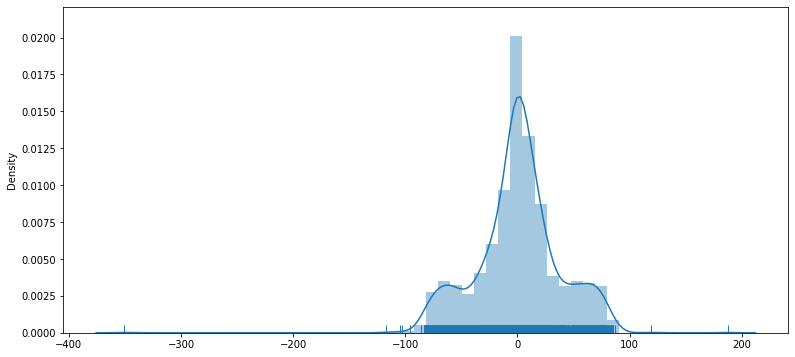

In [ ]:
plt.figure(figsize=(13,6))
sns.distplot(df[['yaw']],rug=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


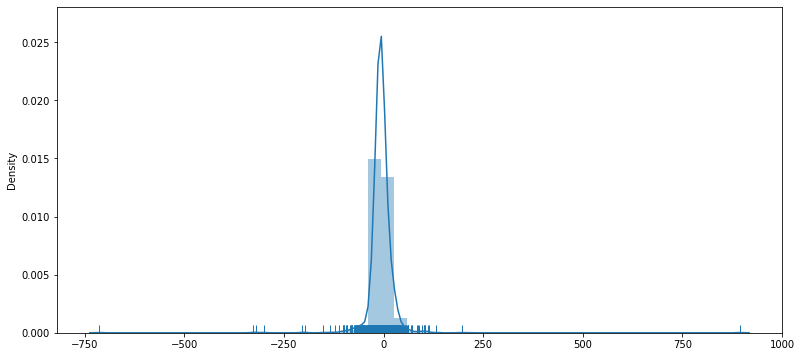

In [ ]:
plt.figure(figsize=(13,6))
sns.distplot(df[['pitch']],rug=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


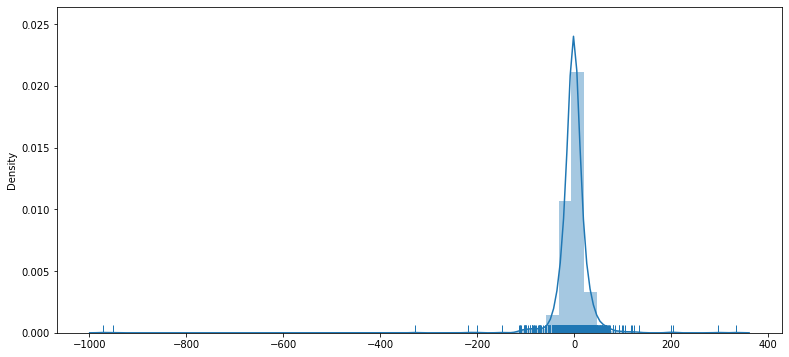

In [ ]:
plt.figure(figsize=(13,6))
sns.distplot(df[['roll']],rug=True)
plt.show()

# Split data

In [ ]:
out=["yaw","pitch","roll"]

In [ ]:
y=df[out]
X=df[df.columns.drop(out)]

In [ ]:
y_yaw=y[['yaw']]
y_pitch=y[['pitch']]
y_roll=y[['roll']]

In [ ]:
#for multiout models without PCA
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [ ]:
#for models with one output without PCA
Xyaw_train, Xyaw_test, yyaw_train, yyaw_test = train_test_split( X, y_yaw, test_size=0.2, random_state=42)
Xpitch_train, Xpitch_test, ypitch_train, ypitch_test = train_test_split( X, y_pitch, test_size=0.2, random_state=42)
Xroll_train, Xroll_test, yroll_train, yroll_test = train_test_split( X, y_roll, test_size=0.2, random_state=42)

# Feature Selection

## Kbest selection on yaw, pitch and roll

In [ ]:
selector1 = SelectKBest(score_func=f_regression, k=10)
selector2 = SelectKBest(score_func=f_regression, k=10)
selector3 = SelectKBest(score_func=f_regression, k=10)

XYaw_selected = selector1.fit_transform(Xyaw_train, yyaw_train)
Xpitch_selected = selector2.fit_transform(Xpitch_train, ypitch_train)
XRoll_selected = selector3.fit_transform(Xroll_train, yroll_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
yaw_filter = selector1.get_support()
pitch_filter = selector2.get_support()
roll_filter = selector3.get_support()

features = np.array(X.columns.values)

print(features[yaw_filter],"\n")
print(features[pitch_filter],"\n")
print(features[roll_filter],"\n")

['x3' 'x4' 'x14' 'x15' 'x29' 'x30' 'x31' 'x33' 'x34' 'x35'] 

['y1' 'y2' 'y3' 'y4' 'y29' 'y30' 'y31' 'y33' 'y34' 'y35'] 

['x7' 'x8' 'x9' 'x23' 'x24' 'x25' 'x43' 'x44' 'y10' 'y21'] 



## PCA 

### PCA on all data for multi-output regressors

In [ ]:
#PCA on all data
pca_all = PCA(n_components=0.99)
pca_xtrain = pca_all.fit_transform(X_train)
#use tranform only on the test set 
pca_xtest = pca_all.transform(X_test)

### PCA for yaw

In [ ]:
#PCA on yaw data
pca_yaw = PCA(n_components=0.99)
pca_xyaw_train = pca_yaw.fit_transform(Xyaw_train)
pca_xyaw_test = pca_yaw.transform(Xyaw_test)

In [ ]:
pca_xyaw_train.shape

(1600, 9)

### PCA for pitch

In [ ]:
pca_pitch = PCA(n_components=0.99)
pca_xpitch_train = pca_pitch.fit_transform(Xpitch_train)
pca_xpitch_test = pca_pitch.transform(Xpitch_test)

### PCA for roll

In [ ]:
pca_roll = PCA(n_components=0.99)
pca_xroll_train = pca_roll.fit_transform(Xroll_train)
pca_xroll_test = pca_roll.transform(Xroll_test)

# Modeling

## MultiOut regressor

In [ ]:
shuffeld_xtrain , shuffeld_ytrain = shuffle(pca_xtrain , y_train , random_state=19)

### Using GradientBoostingRegressor

In [ ]:
#multiOut_model_one = MultiOutputRegressor(GradientBoostingRegressor(random_state=0)).fit(X_train, y_train)
#multiOut_model_two = MultiOutputRegressor(GradientBoostingRegressor(random_state=1,loss='huber',subsample=0.7,criterion='squared_error',n_estimators=150,warm_start=True)).fit(pca_xtrain , y_train)
multiOut_model_gb = MultiOutputRegressor(GradientBoostingRegressor(random_state=1,loss='huber',subsample=0.6,criterion='squared_error',min_samples_leaf=2,warm_start=True,n_estimators=900)).fit(shuffeld_xtrain , shuffeld_ytrain)

In [ ]:
#predictions = multiOut_model_one.predict(X_test)
#pca_predictions = multiOut_model_two.predict(pca_xtest)
shuffle_predictions = multiOut_model_gb.predict(pca_xtest)

In [ ]:
#print(multiOut_model_one.score(X_train, y_train))
#print(multiOut_model_two.score(pca_xtrain, y_train))
print(multiOut_model_gb.score(shuffeld_xtrain , shuffeld_ytrain))

0.7711729864976515


In [ ]:
#print(multiOut_model_one.score(X_test, y_test))
#print(multiOut_model_two.score(pca_xtest, y_test))
print(multiOut_model_gb.score(pca_xtest, y_test))

0.6950400387637171


In [ ]:
#print(mean_squared_error(y_test,predictions,multioutput='raw_values'))
#print(mean_squared_error(y_test,pca_predictions,multioutput='raw_values'))
print(mean_squared_error(y_test,shuffle_predictions,multioutput='raw_values'))

[ 14.10288473 174.03253432 494.31009974]


In [ ]:
 #impFeatures = permutation_importance(multiOut_model_three,pca_xtrain , y_train ,n_repeats=10,random_state=0)

### using RandomForestRegressor

In [ ]:
multiOut_model_rf= MultiOutputRegressor(RandomForestRegressor(random_state=0,bootstrap= True)).fit(shuffeld_xtrain , shuffeld_ytrain)

In [ ]:
predictions = multiOut_model_rf.predict(pca_xtest)

In [ ]:
print(multiOut_model_rf.score(shuffeld_xtrain , shuffeld_ytrain))
print(multiOut_model_rf.score(pca_xtest, y_test))
print(mean_squared_error(y_test,predictions,multioutput='raw_values'))

0.8850104033676502
0.7817577433764668
[  8.43126027 188.27810126 282.4578205 ]


## **Pitch**

In [ ]:
#shuffel data first because it improves accurecy
shuffeld_xpitch_train,shuffeld_pitchtrain = shuffle(pca_xpitch_train,ypitch_train , random_state=19)

### XGBRegressor 

In [ ]:
#perform grid search
param = {'nthread':[4],
              'max_depth': [3,4],
              'min_child_weight': [2,4],
              'subsample': [0.5 ,0.7],
              'colsample_bytree': [0.6,0.7,0.8],
              'n_estimators': [500 ,700]}

xgb_gridsearch = GridSearchCV(XGBRegressor(),
                        param,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [ ]:
#xgb_gridsearchXGB.fit(pca_xyaw_train,yyaw_train)

#print(xgb_gridsearchXGB.best_score_)
#print(xgb_gridsearchXGB.best_params_)

In [ ]:
xgboot_pitchModel = XGBRegressor(n_estimators=300, max_depth=2, subsample=0.7, colsample_bytree=0.8,min_child_weight=4)
xgboot_pitchModel.fit(pca_xpitch_train,ypitch_train)

[17:16:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, max_depth=2, min_child_weight=4,
             n_estimators=300, subsample=0.7)

In [ ]:
predictions = xgboot_pitchModel.predict(pca_xpitch_test)

In [ ]:
print(xgboot_pitchModel.score(pca_xpitch_train,ypitch_train))
print(xgboot_pitchModel.score(pca_xpitch_test, ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.891676915008304
0.35742290531275245
433.5440566686451


### RandomForestRegressor

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [9,10,11],
  #  'max_features': [2,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10 ],
    'n_estimators': [1800,2000,2200],
    'random_state':[7]
}

rf_gridsearch= GridSearchCV( estimator = RandomForestRegressor(), param_grid = param_grid, cv = 3, n_jobs = 5, verbose = True )

In [ ]:
# Fit the grid search to the data
#xgb_gridsearchRF.fit( pca_xyaw_train , yyaw_train )
#xgb_gridsearchRF.best_params_

In [ ]:
randomforest_pitchModel = RandomForestRegressor(random_state=7,bootstrap= True,n_estimators=2500,max_depth=10,)
randomforest_pitchModel.fit( pca_xpitch_train , ypitch_train )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(max_depth=10, n_estimators=2500, random_state=7)

In [ ]:
predictions = randomforest_pitchModel.predict(pca_xpitch_test)

In [ ]:
print(randomforest_pitchModel.score(pca_xpitch_train,ypitch_train))
print(randomforest_pitchModel.score(pca_xpitch_test,ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.7984736697521044
0.5721907112882287
376.8049099665425


### DecisionTreeRegressor

In [ ]:
dt_pitchModel = DecisionTreeRegressor(random_state=0, max_depth=4)

In [ ]:
dt_pitchModel.fit(pca_xpitch_train,ypitch_train)
predictions = dt_pitchModel.predict(pca_xpitch_test)

In [ ]:
print(dt_pitchModel.score(pca_xpitch_train,ypitch_train))
print(dt_pitchModel.score(pca_xpitch_test,ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.824928382419503
0.36604766215076645
558.3711244458234


### GradientBoostingRegressor (Winner model)

In [83]:
gb_pitchModel = GradientBoostingRegressor(random_state=1,subsample=0.5,criterion='squared_error',min_samples_leaf=2,warm_start=False,n_estimators=700)

In [84]:
gb_pitchModel.fit(shuffeld_xpitch_train,shuffeld_pitchtrain)
predictions = gb_pitchModel.predict(pca_xpitch_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [85]:
print(gb_pitchModel.score(shuffeld_xpitch_train,shuffeld_pitchtrain))
print(gb_pitchModel.score(pca_xpitch_test,ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.9977510587006513
0.7820267309115894
115.41329175399719


In [90]:
# save the model to disk
pitch_bestModel = 'pitch_model.sav'
pickle.dump(gb_pitchModel, open(pitch_bestModel, 'wb'))


In [86]:
# load the model from disk
# loaded_model = pickle.load(open(yaw_bestModel, 'rb'))
# result = loaded_model.score(pca_xyaw_test,yyaw_test)
# print(result)

## **yaw**

### XGBRegressor



In [ ]:
xgboot_pitchModel = XGBRegressor(n_estimators=1000, max_depth=4, subsample=0.7, colsample_bytree=0.8)
xgboot_pitchModel.fit(Xpitch_train,ypitch_train)

[19:52:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, max_depth=4, n_estimators=1000,
             subsample=0.7)

In [ ]:
predictions = xgboot_pitchModel.predict(Xpitch_test)

print(xgboot_pitchModel.score(Xpitch_train,ypitch_train))
print(xgboot_pitchModel.score(Xpitch_test, ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.9999985632361985
0.5893189185524488
277.0847942136757


### random forest regressor (Winner model)

In [ ]:
randomforest_yawModel =  RandomForestRegressor(random_state=42)
randomforest_yawModel.fit(pca_xyaw_train,yyaw_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(random_state=42)

In [ ]:
predictions = randomforest_yawModel.predict(pca_xyaw_test)

print("train score: ",randomforest_yawModel.score(pca_xyaw_train,yyaw_train))
print("test score: ",randomforest_yawModel.score(pca_xyaw_test,yyaw_test))
print("mean squared error: ",mean_squared_error(yyaw_test,predictions))

train score:  0.9863760796371822
test score:  0.993569921959072
mean squared error:  8.42734616420774


In [97]:
# save the model to disk
yaw_bestModel = 'yaw_model.sav'
pickle.dump(randomforest_yawModel, open(yaw_bestModel, 'wb'))


## **Roll**

### RandomForestRegressor with random search 

In [ ]:
#n_estimators = [200,500,700,1000,1200]
#
#max_features = ['auto', 'sqrt']
#
#max_depth = [10,30,50,80,100]
#max_depth.append(None)
#
#min_samples_split = [2, 5, 10]
#
#min_samples_leaf = [1, 2, 4]
#
#bootstrap = [True, False]
#
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#print(random_grid)

In [ ]:
#rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#rf_random.fit(pca_xroll_train , yroll_train)

In [ ]:
#rf_random.best_params_

### RandomForestRegressor (winner model)

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,6],
    'max_features': [2,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10 ],
    'n_estimators': [100, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = 5, verbose = True)


In [ ]:
# Fit the grid search to the data
# grid_search.fit(pca_xroll_train , yroll_train)
# grid_search.best_params_

In [ ]:
randomforest_rollModel =   RandomForestRegressor(random_state=1,bootstrap= True,n_estimators=2000,max_depth=10,min_samples_split=4,min_samples_leaf=3,max_features=7)
# random_state=0, bootstrap=False, max_depth=6,
# max_features=5, min_samples_leaf=1,
# min_samples_split=8, n_estimators=300
randomforest_rollModel.fit(pca_xroll_train , yroll_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(max_depth=10, max_features=7, min_samples_leaf=3,
                      min_samples_split=4, n_estimators=2000, random_state=1)

In [ ]:
predictions = randomforest_rollModel.predict(pca_xroll_test)

print(randomforest_rollModel.score(pca_xroll_train,yroll_train))
print(randomforest_rollModel.score(pca_xroll_test,yroll_test))
print(mean_squared_error(yroll_test,predictions))

0.6907700367727927
0.6253891777099857
286.56834744822294


In [98]:
# save the model to disk
roll_bestModel = '/content/gdrive/MyDrive/Colab Notebooks/machine_learning_projects_data/roll_model.sav'
pickle.dump(randomforest_rollModel, open(roll_bestModel, 'wb'))


# Test performance on image

## Extract 68 points

In [ ]:
img = imageio.imread('/content/gdrive/MyDrive/photos/IMG-20210318-WA0107.jpg')
landmarks = extract_face_landmarks(img)
print(landmarks.shape)

(68, 2)


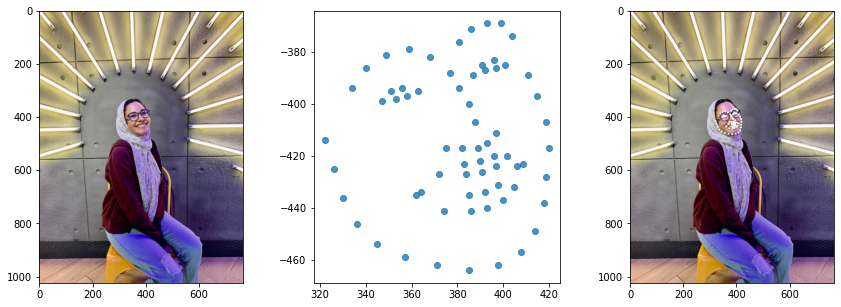

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)
ax = fig.add_subplot(1, 3, 3)
img2 = img.copy()

for p in landmarks:
    img2[p[1]-3:p[1]+3, p[0]-3:p[0]+3, :] = (255, 255, 255)

ax.imshow(img2)
plt.show()

In [ ]:
x_img = (landmarks[:,0])
y_img = (landmarks[:,1])


In [ ]:
features = np.concatenate((x_img,y_img))
features = features.reshape(1,-1)
features.shape

(1, 136)

##  Prepare features

In [ ]:
poses_features = pca_all.transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
yaw_features = pca_yaw.transform(features)
pitch_features = pca_pitch.transform(features)
roll_features = pca_roll.transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


## Test on best models 

In [ ]:
pred = multiOut_model_gb.predict(poses_features)

In [ ]:
pred

array([[ 53.46928272,  19.59500532, -75.78525643]])

In [ ]:
predicted_pitch = gb_pitchModel.predict(pitch_features)
predicted_yaw= randomforest_yawModel.predict(yaw_features)
predicted_roll= randomforest_rollModel.predict(roll_features)

In [ ]:
print(predicted_yaw)
print(predicted_pitch)
print(predicted_roll)
#range of yaw,pitch,and roll should be between -180 and 180

[72.53383331]
[64.22784352]
[-51.05132818]


# Image live processing and prediction

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!wget http://arunponnusamy.com/files/mmod_human_face_detector.dat
!bzip2 -d  '/content/shape_predictor_68_face_landmarks.dat.bz2'

--2022-06-10 19:19:05--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  17.4MB/s    in 3.5s    

2022-06-10 19:19:09 (17.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]

--2022-06-10 19:19:09--  http://arunponnusamy.com/files/mmod_human_face_detector.dat
Resolving arunponnusamy.com (arunponnusamy.com)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to arunponnusamy.com (arunponnusamy.com)|185.199.109.153|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.arunponnusamy.com/files/mmod_human_face_detector.dat [following]
--2022-06-10 19:19:09--  https://www.arunponnusamy.com/f

In [ ]:
predictor=dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()

In [ ]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


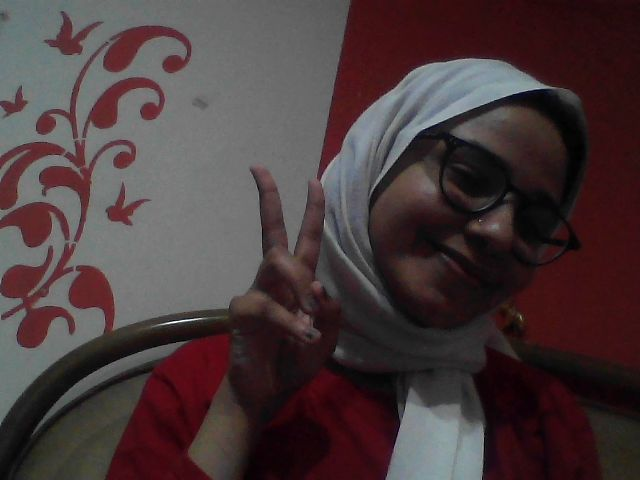

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo_With_prediction(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 

  cv2_frame = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  #get  yaw_pitch_roll from the image
  coords = np.zeros((68, 2), dtype='int')
  rects = detector(cv2_frame, 1)
  for (i, rect) in enumerate(rects):
          shape = predictor(cv2_frame, rect)
          for i in range(0, 68):
              coords[i] = (shape.part(i).x, shape.part(i).y)
  one_sample_yaw = pca_yaw.transform(  coords.reshape(1,136) )
  one_sample_pitch = pca_pitch.transform(  coords.reshape(1,136) )
  one_sample_roll = pca_roll.transform(  coords.reshape(1,136) )
  yaw=randomforest_yawModel.predict(one_sample_yaw)[0]
  pitch=gb_pitchModel.predict(one_sample_pitch)[0]
  roll=randomforest_rollModel.predict(one_sample_roll)[0]
  tdx,tdy=0,0
  for (idx, det) in enumerate(rects):
            print(idx,det , " just")
            # Get x_min, y_min, x_max, y_max, conf
            x_min = det.left()
            y_min = det.top()
            x_max = det.right()-x_min
            y_max = det.bottom()-y_min
            shape = predictor(cv2_frame, det)
            tdx,tdy=shape.part(30).x, shape.part(30).y
  cv2_imshow(draw_axis(img,yaw,pitch,roll ,tdx,tdy ) )

  print("my _ model : " ,yaw,pitch,roll )
  

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


0 [(340, 43) (563, 266)]  just


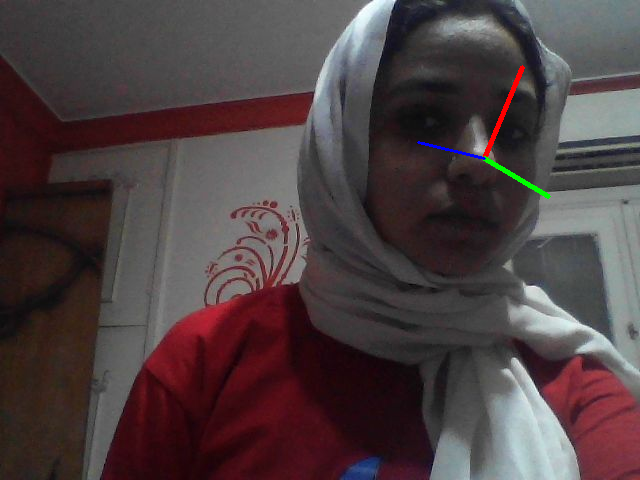

my _ model :  41.26674468755722 11.75362193905708 -59.215652227775365
Saved to None
No image data found. Expecting filename, url, or data.


In [ ]:
from IPython.display import Image
try:
  filename = take_photo_With_prediction()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


0 [(365, 118) (588, 341)]  just


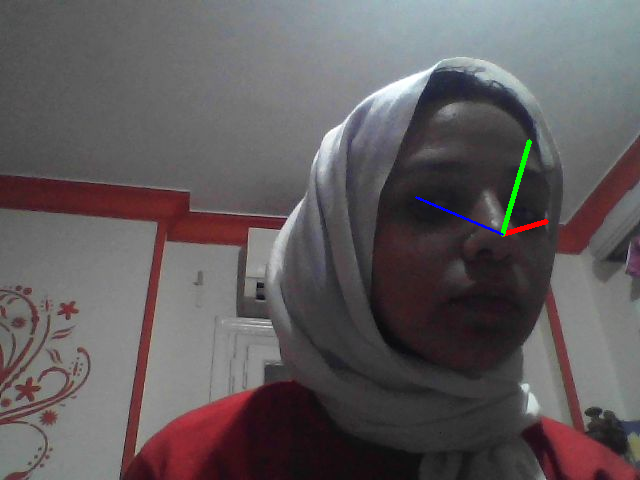

my _ model :  58.62186371564865 135.66425242792835 -32.206223233803215
Saved to None
No image data found. Expecting filename, url, or data.


In [ ]:
from IPython.display import Image
try:
  filename = take_photo_With_prediction()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename)) 
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#Video live processing

In [96]:
import cv2
import dlib
import pickle
import numpy as np
from math import cos, sin
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# MinMaxScaler
# StandardScaler
scale= StandardScaler()

roll_model = 'roll_model.sav'
yaw_model = 'yaw_model.sav'
pitch_model = 'pitch_model.sav'



cap = cv2.VideoCapture(0)

hog_face_detector = dlib.get_frontal_face_detector()

dlib_facelandmark = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")


loaded_model_yaw = pickle.load(open(yaw_model, 'rb'))
loaded_model_roll = pickle.load(open(roll_model, 'rb'))
loaded_model_pitch= pickle.load(open(pitch_model, 'rb'))
while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = hog_face_detector(gray)
    for face in faces:

        face_landmarks = dlib_facelandmark(gray, face)
        # print(face_landmarks)
        
        tst=[]
        
        for n in range(0, 68):
            x = face_landmarks.part(n).x
            y = face_landmarks.part(n).y
            tst.append(x)
            tst.append(y)
            cv2.circle(frame, (x, y), 1, (36,255,12), 3)
        tst=np.array(tst).reshape(1,-1)
        scaled_data = scale.fit_transform(tst) 

        yhat_yaw=loaded_model_yaw.predict(scaled_data)
        yhat_pitch=loaded_model_pitch.predict(tst)
        yhat_roll=loaded_model_roll.predict(tst)
        
        
        cv2.putText(frame, "Yaw: "+str(yhat_yaw), (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 2)
        cv2.putText(frame, "pitch: "+str(yhat_pitch), (20,60), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 2)
        cv2.putText(frame, "roll: "+str(yhat_roll), (20,80), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 2)
   
   

    cv2.imshow("Face Landmarks",draw_axis(frame,yhat_yaw,yhat_pitch,yhat_roll
                                 ,tst[:,60],tst[:,61])
            )
    # cv2.imshow("Face Landmarks", frame)

    key = cv2.waitKey(1)
    if key == 27:
        break
cap.release()
cv2.destroyAllWindows()

error: ignored